In [1]:
pip install tikzplotlib

Note: you may need to restart the kernel to use updated packages.


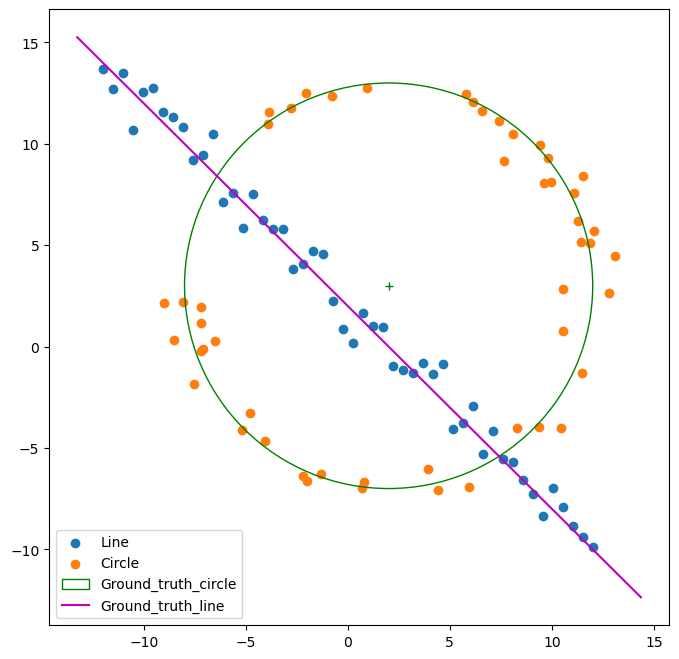

In [9]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
# np.random.seed(0)
N= 100
half_n =N//2

r = 10
x0_gt , y0_gt = 2, 3 # Center
s = r/16
t = np.random.uniform(0, 2*np.pi , half_n)
n = s*np.random.randn(half_n)
x, y = x0_gt + (r + n)*np.cos(t), y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n ,1) , y.reshape(half_n ,1)))
s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n ,1) , y.reshape(half_n ,1)))
X = np.vstack((X_circ , X_line )) # All points
fig , ax = plt.subplots(1,1, figsize =(8 ,8))
ax. scatter (X_line [: ,0] , X_line [: ,1] , label= 'Line')
ax. scatter ( X_circ [: ,0] , X_circ [: ,1] , label= 'Circle' )
circle_gt = plt . Circle ((x0_gt ,y0_gt) , r , color= 'g' , fill=False , label='Ground_truth_circle')
ax. add_patch( circle_gt )
ax. plot (( x0_gt) , (y0_gt) , '+' , color= 'g' )
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt . plot (x_ , y_, color= 'm' , label='Ground_truth_line')
plt . legend ()

In [3]:
def ransac_line(X, threshold, max_iter=1000):
    best_inliers = []
    best_model = None

    for _ in range(max_iter):
        # Sample two random points
        sample = X[np.random.choice(X.shape[0], 2, replace=False)]
        p1, p2 = sample

        # Define the line using the cross product to find [a, b, d]
        line = np.cross(np.append(p1, 1), np.append(p2, 1))  # ax + by + d = 0
        a, b, d = line[0], line[1], line[2]

        # Normalize [a, b] to satisfy ∥[a, b]⊺∥ = 1
        norm_factor = np.sqrt(a**2 + b**2)
        a, b, d = a / norm_factor, b / norm_factor, d / norm_factor

        # Compute the normal distance of all points to the line
        normal = np.array([a, b])
        distances = np.abs(np.dot(X, normal) + d) / np.linalg.norm(normal)

        # Select inliers where the distance is less than the threshold
        inliers = X[distances < threshold]

        # Update best model if the number of inliers is greater than previous best
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = (a, b, d)

    return best_model, best_inliers


Best line model parameters (a, b, d): (-0.7299222360562079, -0.6835301963415411, 1.6054724194842065)


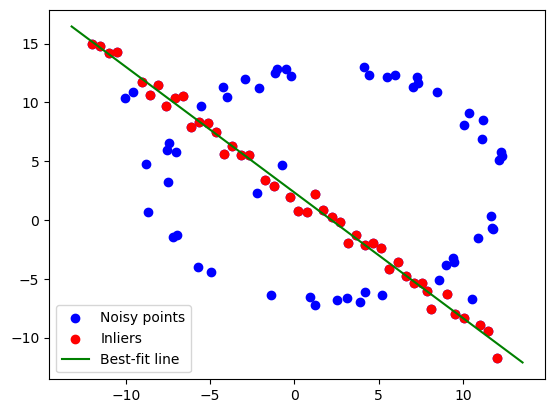

In [4]:
best_model, best_inliers = ransac_line(X, threshold=0.9)
print("Best line model parameters (a, b, d):", best_model)

# Plot best line fit
# Plot the noisy points and inliers
plt.scatter(X[:, 0], X[:, 1], color='blue', label='Noisy points')
plt.scatter(best_inliers[:, 0], best_inliers[:, 1], color='red', label='Inliers')

# Get the current plot limits
x_min, x_max = plt.xlim()

# Calculate the corresponding y values using the line equation ax + by + d = 0
# Rearranged to y = -(a/b)x - d/b, if b != 0
if best_model is not None:
    a, b, d = best_model
    if b != 0:
        y_min = -(a * x_min + d) / b
        y_max = -(a * x_max + d) / b
        plt.plot([x_min, x_max], [y_min, y_max], color='green', label='Best-fit line')

# Add legend and show the plot
plt.legend()
plt.show()


Circle center (x, y), radius: (2.0630655154582405, 3.017291249929898, 10.066119710130742)


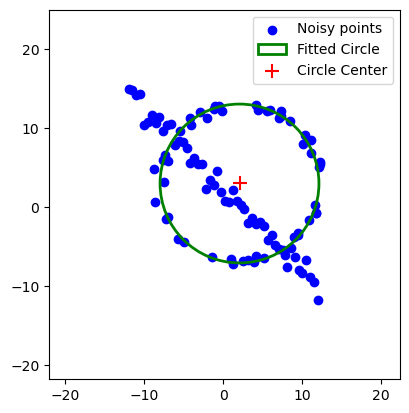

In [5]:
from scipy.optimize import minimize

# Define function for fitting a circle
def fit_circle(points):
    def calc_R(xc, yc):
        return np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)

    def f_2(c):
        Ri = calc_R(*c)
        return np.std(Ri)

    center_estimate = np.mean(points, axis=0)
    center_optimized = minimize(f_2, center_estimate).x
    radii = calc_R(*center_optimized)
    return center_optimized[0], center_optimized[1], np.mean(radii)

# Fit the circle using RANSAC or the fit_circle function
circle_model = fit_circle(X_circ)
xc, yc, radius = circle_model
print("Circle center (x, y), radius:", circle_model)

# Plot the noisy points (both line and circle points if mixed)
plt.scatter(X[:, 0], X[:, 1], color='blue', label='Noisy points')

# Plot the fitted circle
circle = plt.Circle((xc, yc), radius, color='green', fill=False, linewidth=2, label='Fitted Circle')
plt.gca().add_patch(circle)

# Optionally plot the circle center
plt.scatter(xc, yc, color='red', marker='+', s=100, label='Circle Center')

# Adjust the plot limits to ensure the entire circle is visible
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(min(X[:, 0]) - radius, max(X[:, 0]) + radius)
plt.ylim(min(X[:, 1]) - radius, max(X[:, 1]) + radius)

# Add legend and show the plot
plt.legend()
plt.show()


Circle center (x, y), radius: (2.0630655154582405, 3.017291249929898, 10.066119710130742)


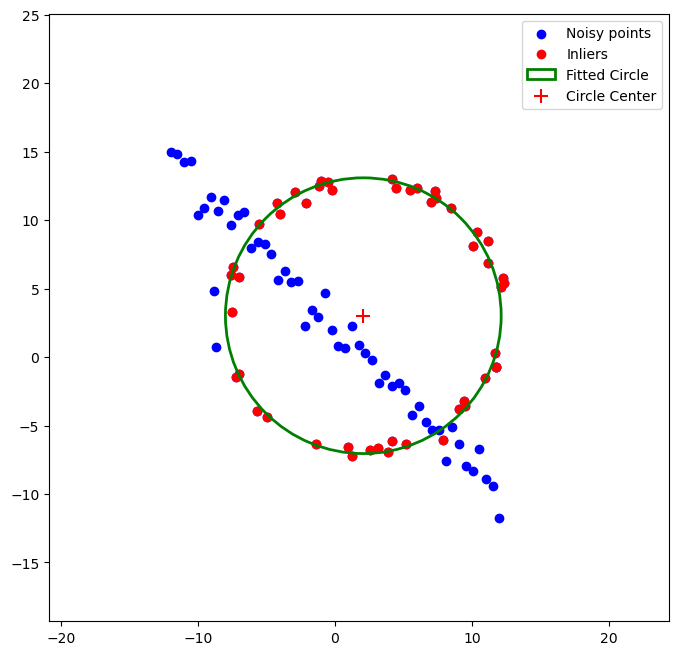

In [6]:
from scipy.optimize import minimize

# Define function for fitting a circle
def fit_circle(points):
    # Function to calculate the distance from the center (xc, yc) to each point
    def calc_R(xc, yc):
        return np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)

    # Objective function to minimize: the standard deviation of radii
    def f_2(c):
        Ri = calc_R(*c)
        return np.std(Ri)

    # Initial guess for the center (mean of the points)
    center_estimate = np.mean(points, axis=0)

    # Minimize the objective function to find the best circle center
    center_optimized = minimize(f_2, center_estimate).x

    # Calculate the radius as the mean distance from the center
    radii = calc_R(*center_optimized)
    return center_optimized[0], center_optimized[1], np.mean(radii)

# Function to find inliers based on radial distance
def find_inliers(points, xc, yc, radius, threshold):
    distances = np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)
    inliers = points[np.abs(distances - radius) < threshold]
    return inliers

# Fit the circle using the fit_circle function
xc, yc, radius = fit_circle(X_circ)
print("Circle center (x, y), radius:", (xc, yc, radius))

# Find inliers (points that lie close to the fitted circle)
threshold = 0.9  # Define a threshold for inliers
inliers = find_inliers(X_circ, xc, yc, radius, threshold)


fig , ax = plt.subplots(1,1, figsize =(8 ,8))

# Plot all noisy points
# plt.scatter(X_circ[:, 0], X_circ[:, 1], color='blue', label='Noisy points')
ax.scatter(X[:, 0], X[:, 1], color='blue', label='Noisy points')

# Plot the inliers (points that fit the circle well)
ax.scatter(inliers[:, 0], inliers[:, 1], color='red', label='Inliers')

# Plot the fitted circle
circle = plt.Circle((xc, yc), radius, color='green', fill=False, linewidth=2, label='Fitted Circle')
plt.gca().add_patch(circle)

# Optionally plot the circle center
ax.scatter(xc, yc, color='red', marker='+', s=100, label='Circle Center')

# Adjust the plot limits to ensure the entire circle is visible
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(min(X_circ[:, 0]) - radius - 2, max(X_circ[:, 0]) + radius + 2)
plt.ylim(min(X_circ[:, 1]) - radius - 2, max(X_circ[:, 1]) + radius + 2)

# Add legend and show the plot
plt.legend()
plt.show()


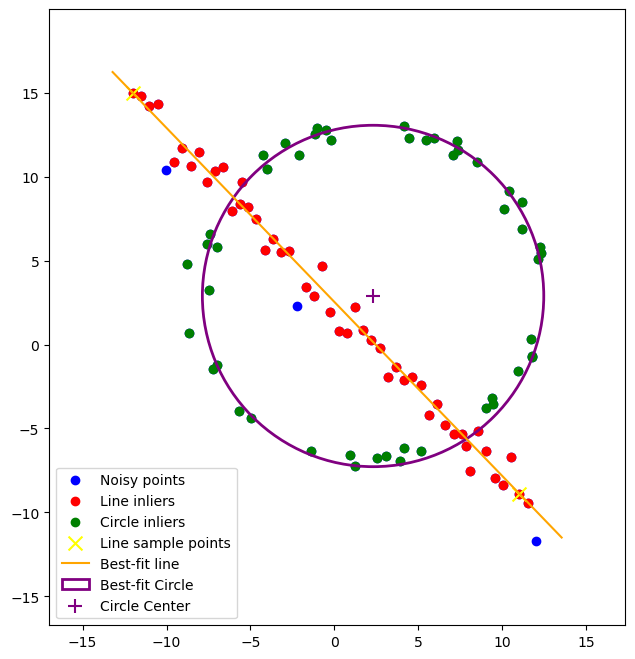

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to fit a circle
def fit_circle(points):
    def calc_R(xc, yc):
        return np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)

    def f_2(c):
        Ri = calc_R(*c)
        return np.std(Ri)

    center_estimate = np.mean(points, axis=0)
    center_optimized = minimize(f_2, center_estimate).x
    radii = calc_R(*center_optimized)
    return center_optimized[0], center_optimized[1], np.mean(radii)

# RANSAC for line fitting
def ransac_line(X, threshold, max_iter=1000):
    best_inliers = []
    best_model = None
    best_sample = None

    for _ in range(max_iter):
        # Sample two random points
        sample = X[np.random.choice(X.shape[0], 2, replace=False)]
        p1, p2 = sample

        # Define the line using the cross product to find [a, b, d]
        line = np.cross(np.append(p1, 1), np.append(p2, 1))  # ax + by + d = 0
        a, b, d = line[0], line[1], line[2]

        # Normalize [a, b]
        norm_factor = np.sqrt(a**2 + b**2)
        a, b, d = a / norm_factor, b / norm_factor, d / norm_factor

        # Compute the normal distance of all points to the line
        normal = np.array([a, b])
        distances = np.abs(np.dot(X, normal) + d) / np.linalg.norm(normal)

        # Select inliers where the distance is less than the threshold
        inliers = X[distances < threshold]

        # Update best model if the number of inliers is greater than previous best
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = (a, b, d)
            best_sample = sample

    return best_model, best_inliers, best_sample

# Function to find inliers for circle fitting
def find_circle_inliers(points, xc, yc, radius, threshold):
    distances = np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)
    inliers = points[np.abs(distances - radius) < threshold]
    return inliers

# Generate noisy circle and line data
np.random.seed(0)
N = 100
half_n = N // 2

# # Circle data
# r = 10
# x0_gt, y0_gt = 2, 3  # Ground truth circle center
# theta = np.random.uniform(0, 2 * np.pi, half_n)
# n = r / 16 * np.random.randn(half_n)
# x_circ = x0_gt + (r + n) * np.cos(theta)
# y_circ = y0_gt + (r + n) * np.sin(theta)
# X_circ = np.vstack((x_circ, y_circ)).T

# # Line data
# s_line = 1.
# m, b = -1, 2  # Ground truth line slope and intercept
# x_line = np.linspace(-12, 12, half_n)
# y_line = m * x_line + b + s_line * np.random.randn(half_n)
# X_line = np.vstack((x_line, y_line)).T

# # Combine circle and line points
# X = np.vstack((X_circ, X_line))

# Fit the line using RANSAC
best_line_model, line_inliers, line_sample = ransac_line(X, threshold=1.2)
a, b, d = best_line_model

# Fit the circle after removing line inliers
X_remnant = np.array([pt for pt in X if pt not in line_inliers])
xc, yc, radius = fit_circle(X_remnant)

# Find circle inliers
circle_inliers = find_circle_inliers(X_remnant, xc, yc, radius, threshold=1.2)

# Plot everything
plt.figure(figsize=(8, 8))

# Plot all noisy points
plt.scatter(X[:, 0], X[:, 1], color='blue', label='Noisy points')

# Plot line inliers
plt.scatter(line_inliers[:, 0], line_inliers[:, 1], color='red', label='Line inliers')

# Plot circle inliers
plt.scatter(circle_inliers[:, 0], circle_inliers[:, 1], color='green', label='Circle inliers')

# Plot the sample points that led to the best line estimate
plt.scatter(line_sample[:, 0], line_sample[:, 1], color='yellow', s=100, marker='x', label='Line sample points')

# Plot the best-fit line
x_min, x_max = plt.xlim()
y_min = -(a * x_min + d) / b
y_max = -(a * x_max + d) / b
plt.plot([x_min, x_max], [y_min, y_max], color='orange', label='Best-fit line')

# Plot the best-fit circle
circle = plt.Circle((xc, yc), radius, color='purple', fill=False, linewidth=2, label='Best-fit Circle')
plt.gca().add_patch(circle)

# Optionally, plot the circle center
plt.scatter(xc, yc, color='purple', marker='+', s=100, label='Circle Center')

# Adjust the plot limits
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(min(X[:, 0]) - 5, max(X[:, 0]) + 5)
plt.ylim(min(X[:, 1]) - 5, max(X[:, 1]) + 5)

# Add legend and show the plot
plt.legend()
plt.show()


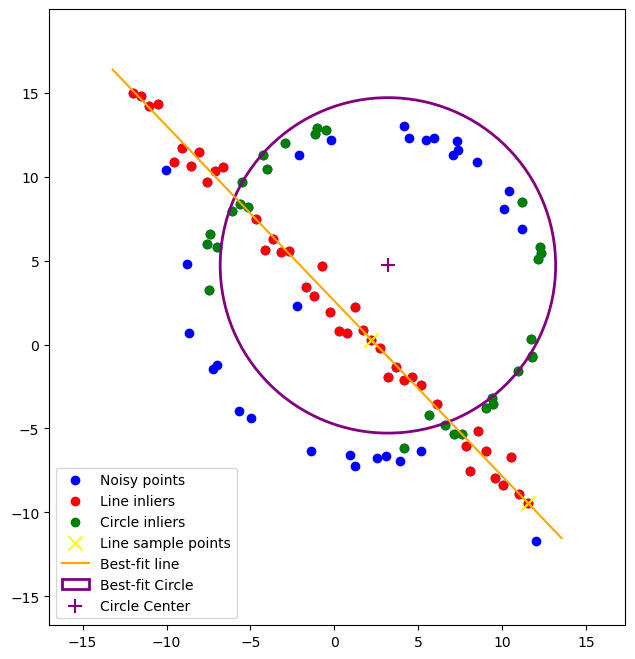

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to fit a circle
def fit_circle(points):
    def calc_R(xc, yc):
        return np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)

    def f_2(c):
        Ri = calc_R(*c)
        return np.std(Ri)

    center_estimate = np.mean(points, axis=0)
    center_optimized = minimize(f_2, center_estimate).x
    radii = calc_R(*center_optimized)
    return center_optimized[0], center_optimized[1], np.mean(radii)

# RANSAC for line fitting
def ransac_line(X, threshold, max_iter=1000):
    best_inliers = []
    best_model = None
    best_sample = None

    for _ in range(max_iter):
        # Sample two random points
        sample = X[np.random.choice(X.shape[0], 2, replace=False)]
        p1, p2 = sample

        # Define the line using the cross product to find [a, b, d]
        line = np.cross(np.append(p1, 1), np.append(p2, 1))  # ax + by + d = 0
        a, b, d = line[0], line[1], line[2]

        # Normalize [a, b]
        norm_factor = np.sqrt(a**2 + b**2)
        a, b, d = a / norm_factor, b / norm_factor, d / norm_factor

        # Compute the normal distance of all points to the line
        normal = np.array([a, b])
        distances = np.abs(np.dot(X, normal) + d) / np.linalg.norm(normal)

        # Select inliers where the distance is less than the threshold
        inliers = X[distances < threshold]

        # Update best model if the number of inliers is greater than previous best
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = (a, b, d)
            best_sample = sample

    return best_model, best_inliers, best_sample

# Function to find inliers for circle fitting
def find_circle_inliers(points, xc, yc, radius, threshold):
    distances = np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)
    inliers = points[np.abs(distances - radius) < threshold]
    return inliers

# Generate noisy circle and line data
np.random.seed(0)
N = 100
half_n = N // 2

# # Circle data
# r = 10
# x0_gt, y0_gt = 2, 3  # Ground truth circle center
# theta = np.random.uniform(0, 2 * np.pi, half_n)
# n = r / 16 * np.random.randn(half_n)
# x_circ = x0_gt + (r + n) * np.cos(theta)
# y_circ = y0_gt + (r + n) * np.sin(theta)
# X_circ = np.vstack((x_circ, y_circ)).T

# # Line data
# s_line = 1.
# m, b = -1, 2  # Ground truth line slope and intercept
# x_line = np.linspace(-12, 12, half_n)
# y_line = m * x_line + b + s_line * np.random.randn(half_n)
# X_line = np.vstack((x_line, y_line)).T

# # Combine circle and line points
# X = np.vstack((X_circ, X_line))


# Find circle inliers
xc, yc, radius = fit_circle(X)
circle_inliers = find_circle_inliers(X, xc, yc, radius, threshold=1.2)

# Fit the circle after removing line inliers
X_remnant = np.array([pt for pt in X if pt not in circle_inliers])

# Fit the line using RANSAC
best_line_model, line_inliers, line_sample = ransac_line(X_remnant, threshold=1.2)
a, b, d = best_line_model

# Plot everything
plt.figure(figsize=(8, 8))

# Plot all noisy points
plt.scatter(X[:, 0], X[:, 1], color='blue', label='Noisy points')

# Plot line inliers
plt.scatter(line_inliers[:, 0], line_inliers[:, 1], color='red', label='Line inliers')

# Plot circle inliers
plt.scatter(circle_inliers[:, 0], circle_inliers[:, 1], color='green', label='Circle inliers')

# Plot the sample points that led to the best line estimate
plt.scatter(line_sample[:, 0], line_sample[:, 1], color='yellow', s=100, marker='x', label='Line sample points')

# Plot the best-fit line
x_min, x_max = plt.xlim()
y_min = -(a * x_min + d) / b
y_max = -(a * x_max + d) / b
plt.plot([x_min, x_max], [y_min, y_max], color='orange', label='Best-fit line')

# Plot the best-fit circle
circle = plt.Circle((xc, yc), radius, color='purple', fill=False, linewidth=2, label='Best-fit Circle')
plt.gca().add_patch(circle)

# Optionally, plot the circle center
plt.scatter(xc, yc, color='purple', marker='+', s=100, label='Circle Center')

# Adjust the plot limits
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(min(X[:, 0]) - 5, max(X[:, 0]) + 5)
plt.ylim(min(X[:, 1]) - 5, max(X[:, 1]) + 5)

# Add legend and show the plot
plt.legend()
plt.show()
